# Sampling plans and Gaussian process regression models

In [1]:
import numpy as np
import scipy as sp
import pymc3 as pm
import thesis

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In this work we frequently make use of Gaussian process regression (GPR) in order to interpolate a function which is poorly sampled, and expensive to sample.

In order to better understand both the optimal choice of training data for a GPR model, and how we might use this to inform the design of future experiments we will turn to the use of a function which is fairly cheap to evaluate, but has a non-trivial topology, being both non-convex, and with a minimum which is difficult to find numerically. This function, the *Rosenbrock function*, is widely used to test numerical optimisation algorithms, although we will initially use it for the purpose of experimental design.

In [3]:
def rosen_function(x):
    """
    The Rosenbrock function.
    """
    f = 0
    for i in range(len(x)-1):
        f += 100*((x[i]**2)-x[i+1])**2+\
        (1-x[i])**2
    return f

To illustrate the function we first sample it densely and produce a contour plot.

In [4]:
x = np.linspace(-2,2, 1000)
y = np.linspace(-2,2, 1000)
xy = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
rosen = np.array([rosen_function(xx) for xx in xy])

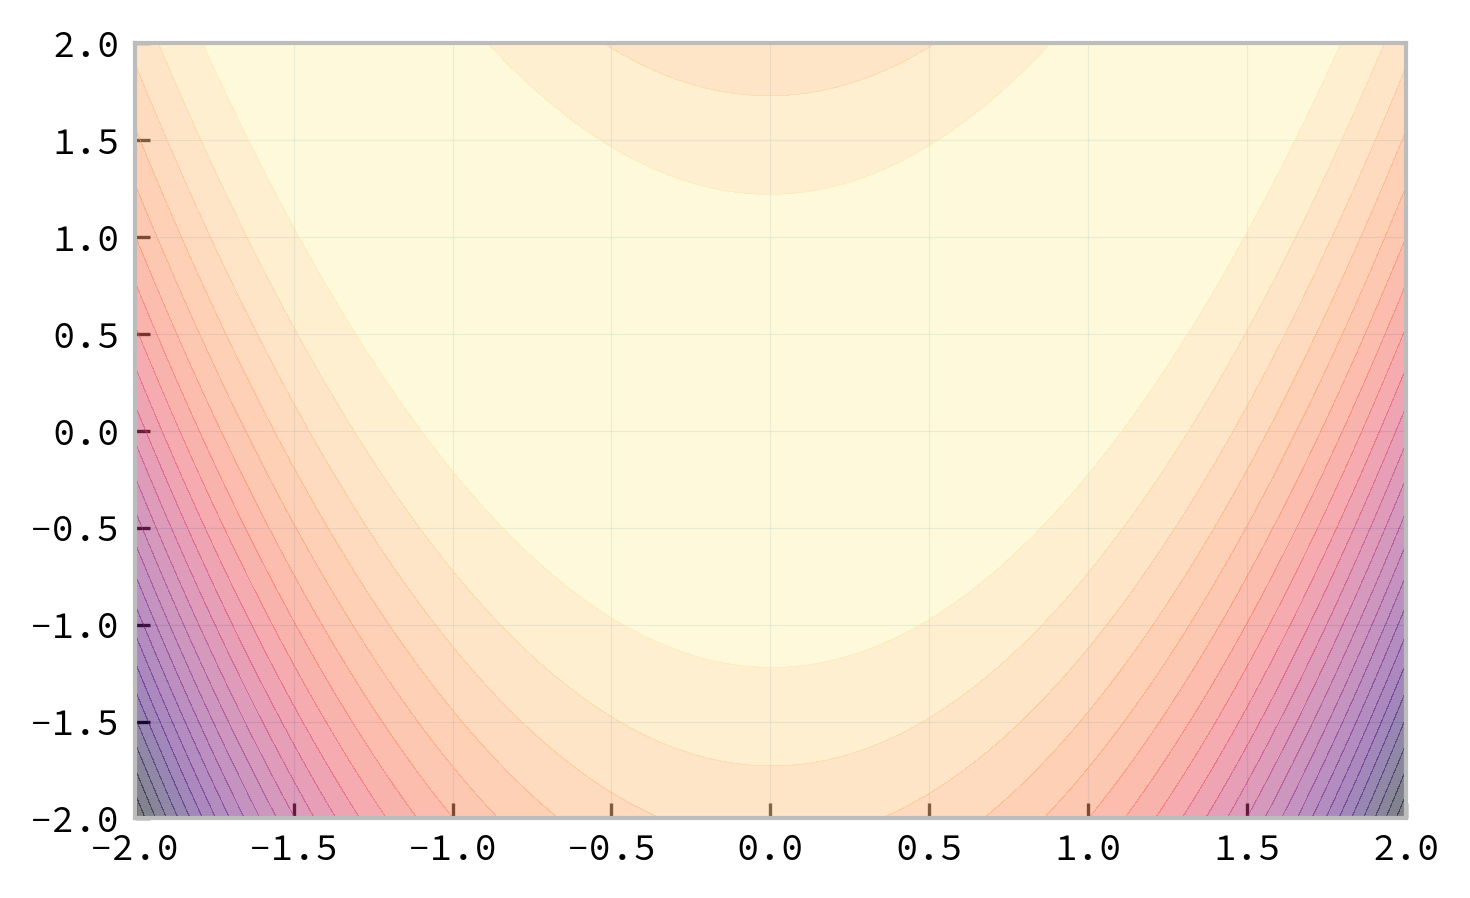

In [5]:
f, ax = plt.subplots(1,1, dpi=300)
ax.contourf(x, y, rosen.reshape(1000,1000), levels=np.arange(0, 3610, 150), zorder=1, alpha=0.5)
ax.grid(which="both", zorder=99)
f = thesis.thesisify(f);
f.tight_layout()
f.savefig("../../figures/gp/rosenbrock-function.pdf")

# Randomly selected initial data

Perhaps the simplest way to design an experiment to explore this function is to simply choose random points within its parameter space, and evaluate it there. As an example, let's take thirty points at random.

In [6]:
np.random.seed(300)

In [7]:
choice = np.random.choice(len(xy), 25)

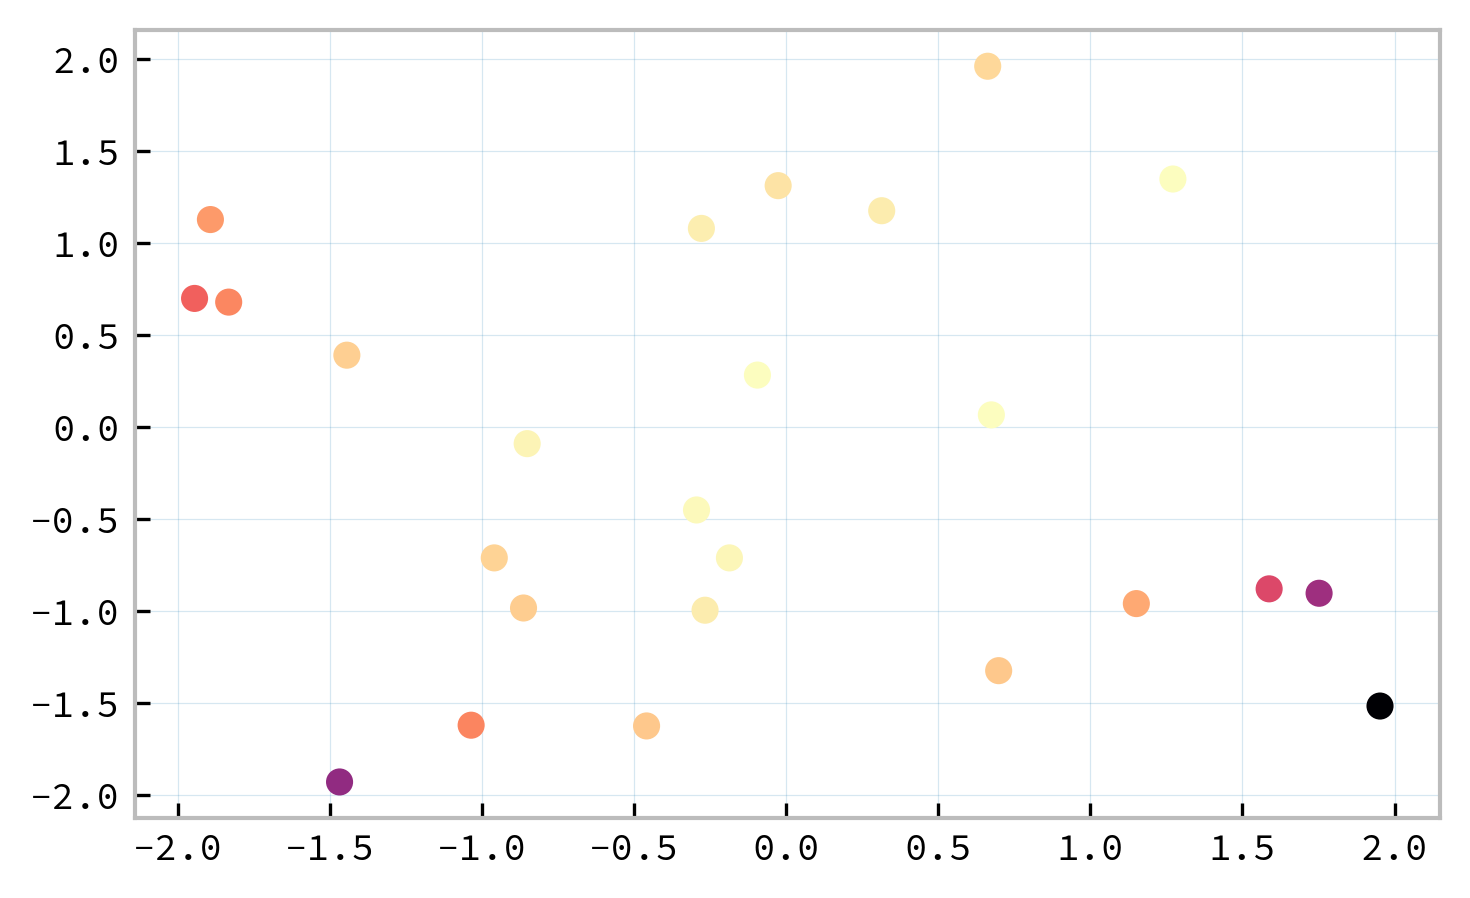

In [8]:
f, ax = plt.subplots(1,1, dpi=300)
ax.scatter(xy[choice, 0], xy[choice, 1], c=rosen[choice])
ax.grid(which="both", zorder=99)
f = thesis.thesisify(f);
f.tight_layout()
f.savefig("../../figures/gp/rosen-random-training.pdf")

We can then construct a Gaussian process conditioned on these data, and plot the interpolated function.

In [9]:
with pm.Model() as model:
    
    amp = pm.Normal("amplitude", 1, 1)
    ls = pm.Normal("metric", mu=[1, 1.], sd=1, shape=2) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
    #ls = pm.Gamma("metric", alpha=.03, beta=0.015, shape=2)
    #period = pm.Gamma("period", alpha=1, beta=0.5)
    alpha = pm.Gamma("alpha", alpha=5, beta=.5, shape=1)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.ExpQuad(2, ls=ls) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=xy[choice], y=rosen[choice], noise=sigma)

/home/daniel/.virtualenvs/aries/thesis2/local/lib/python2.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [10]:
with model:
    mp = pm.find_MAP()

/home/daniel/.virtualenvs/aries/thesis2/local/lib/python2.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
logp = -59,335, ||grad|| = 7,917.3: 100%|██████████| 81/81 [00:00<00:00, 453.58it/s]         


In [11]:
x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)
xy_pred = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

with model:
    mu, var = gp.predict(xy_pred, point=mp, diag=True)
    sd = np.sqrt(var)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


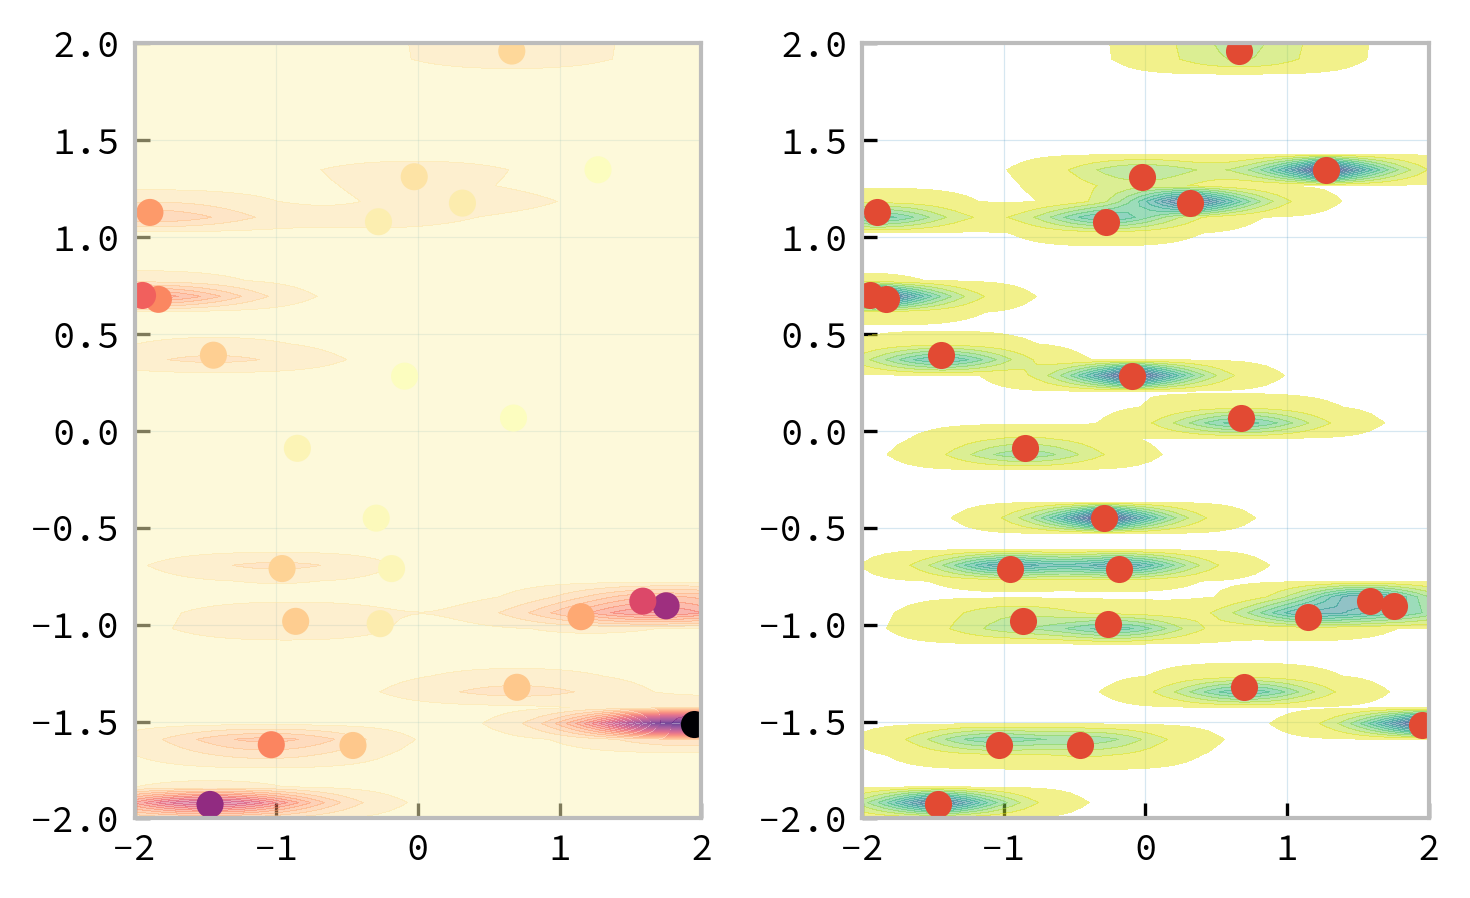

In [12]:
f, ax = plt.subplots(1,2, dpi=300)
ax[0].contourf(x, y, mu.reshape(50,50), levels=np.arange(-100, 3610, 150), zorder=1, alpha=0.5)
ax[0].grid(which="both", zorder=99)

ax[0].scatter(xy[choice, 0], xy[choice, 1], c=rosen[choice])

ax[1].contourf(x, y, sd.reshape(50,50), levels=np.arange(0, 15, 1), zorder=1, alpha=0.5, cmap='viridis')
ax[1].grid(which="both", zorder=99)

ax[1].scatter(xy[choice, 0], xy[choice, 1])#, c=rosen[choice])

ax[0].set_xlim([-2,2])
ax[0].set_ylim([-2,2])

ax[1].set_xlim([-2,2])
ax[1].set_ylim([-2,2])

f = thesis.thesisify(f);

f.tight_layout()
f.savefig("../../figures/gp/rosen-random-trained-25.pdf")

The plot in the left panel represents the mean function produced by the GPR, while the right is the variance in the 
Clearly such a small number of points is insufficient to produce a high-quality estimate of the underlying function. 

To see how bad this is we need to define some metric. The normalised root-mean-squared error seems reasonable in this case.

In [13]:
def rmse(reality, prediction):
    return np.sqrt(np.mean((reality - prediction)/reality)**2)

In [14]:
reality = np.array([rosen_function(xx) for xx in xy_pred])

print(rmse(reality, mu))

0.2663930024378428


In order to see how many samples are required to produce a low RMSE using this method we can repeat it for a different number of samples.

In [15]:
rmses_random = []
mus_random = []
std_random = []

np.random.seed(300)

x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)
xy= np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
rosen = np.array([rosen_function(xx) for xx in xy])

for samples in np.arange(5, 11, 1)**2:
    
    choice = np.random.choice(len(xy), samples)
    
    with pm.Model() as model:
    
        amp = pm.Normal("amplitude", 1, 1)
        ls = [0.012, 0.012] #
        ls = pm.Normal("metric", mu=[.1, .1], sd=1, shape=2) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
        #ls = pm.Gamma("metric", alpha=.03, beta=0.015, shape=2)
        #period = pm.Gamma("period", alpha=1, beta=0.5)
        alpha = pm.Gamma("alpha", alpha=5, beta=.5, shape=1)
        # Specify the covariance function.
        cov_func = amp * pm.gp.cov.ExpQuad(2, ls=[1, 1]) #+ pm.gp.cov.WhiteNoise(1)

        # Specify the GP.  The default mean function is `Zero`.
        gp = pm.gp.Marginal(cov_func=cov_func)

        # 
        sigma = pm.Normal("sigma", 0.1, 0.001)
        y_ = gp.marginal_likelihood("y", X=xy[choice], y=rosen[choice], noise=sigma)
        
        mp = pm.find_MAP()

    x = np.linspace(-2,2, 50)
    y = np.linspace(-2,2, 50)
    xy_pred = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    with model:
        mu, var = gp.predict(xy_pred, point=mp, diag=True)
        sd = np.sqrt(var)
        
    rmses_random.append(rmse(reality, mu))
    mus_random.append(mu)
    std_random.append(sd)

logp = -1.3203e+05, ||grad|| = 1.4347: 100%|██████████| 38/38 [00:00<00:00, 323.90it/s]      
logp = -1.1236e+05, ||grad|| = 4,588.8: 100%|██████████| 28/28 [00:00<00:00, 236.72it/s]    
logp = -1.8481e+05, ||grad|| = 40.023: 100%|██████████| 36/36 [00:00<00:00, 209.09it/s]      
logp = -1.8234e+05, ||grad|| = 1.6655e+05: 100%|██████████| 28/28 [00:00<00:00, 203.09it/s]  
logp = -1.8272e+05, ||grad|| = 27,799: 100%|██████████| 30/30 [00:00<00:00, 180.84it/s]      
logp = -2.3739e+05, ||grad|| = 38,150: 100%|██████████| 30/30 [00:00<00:00, 154.91it/s]      


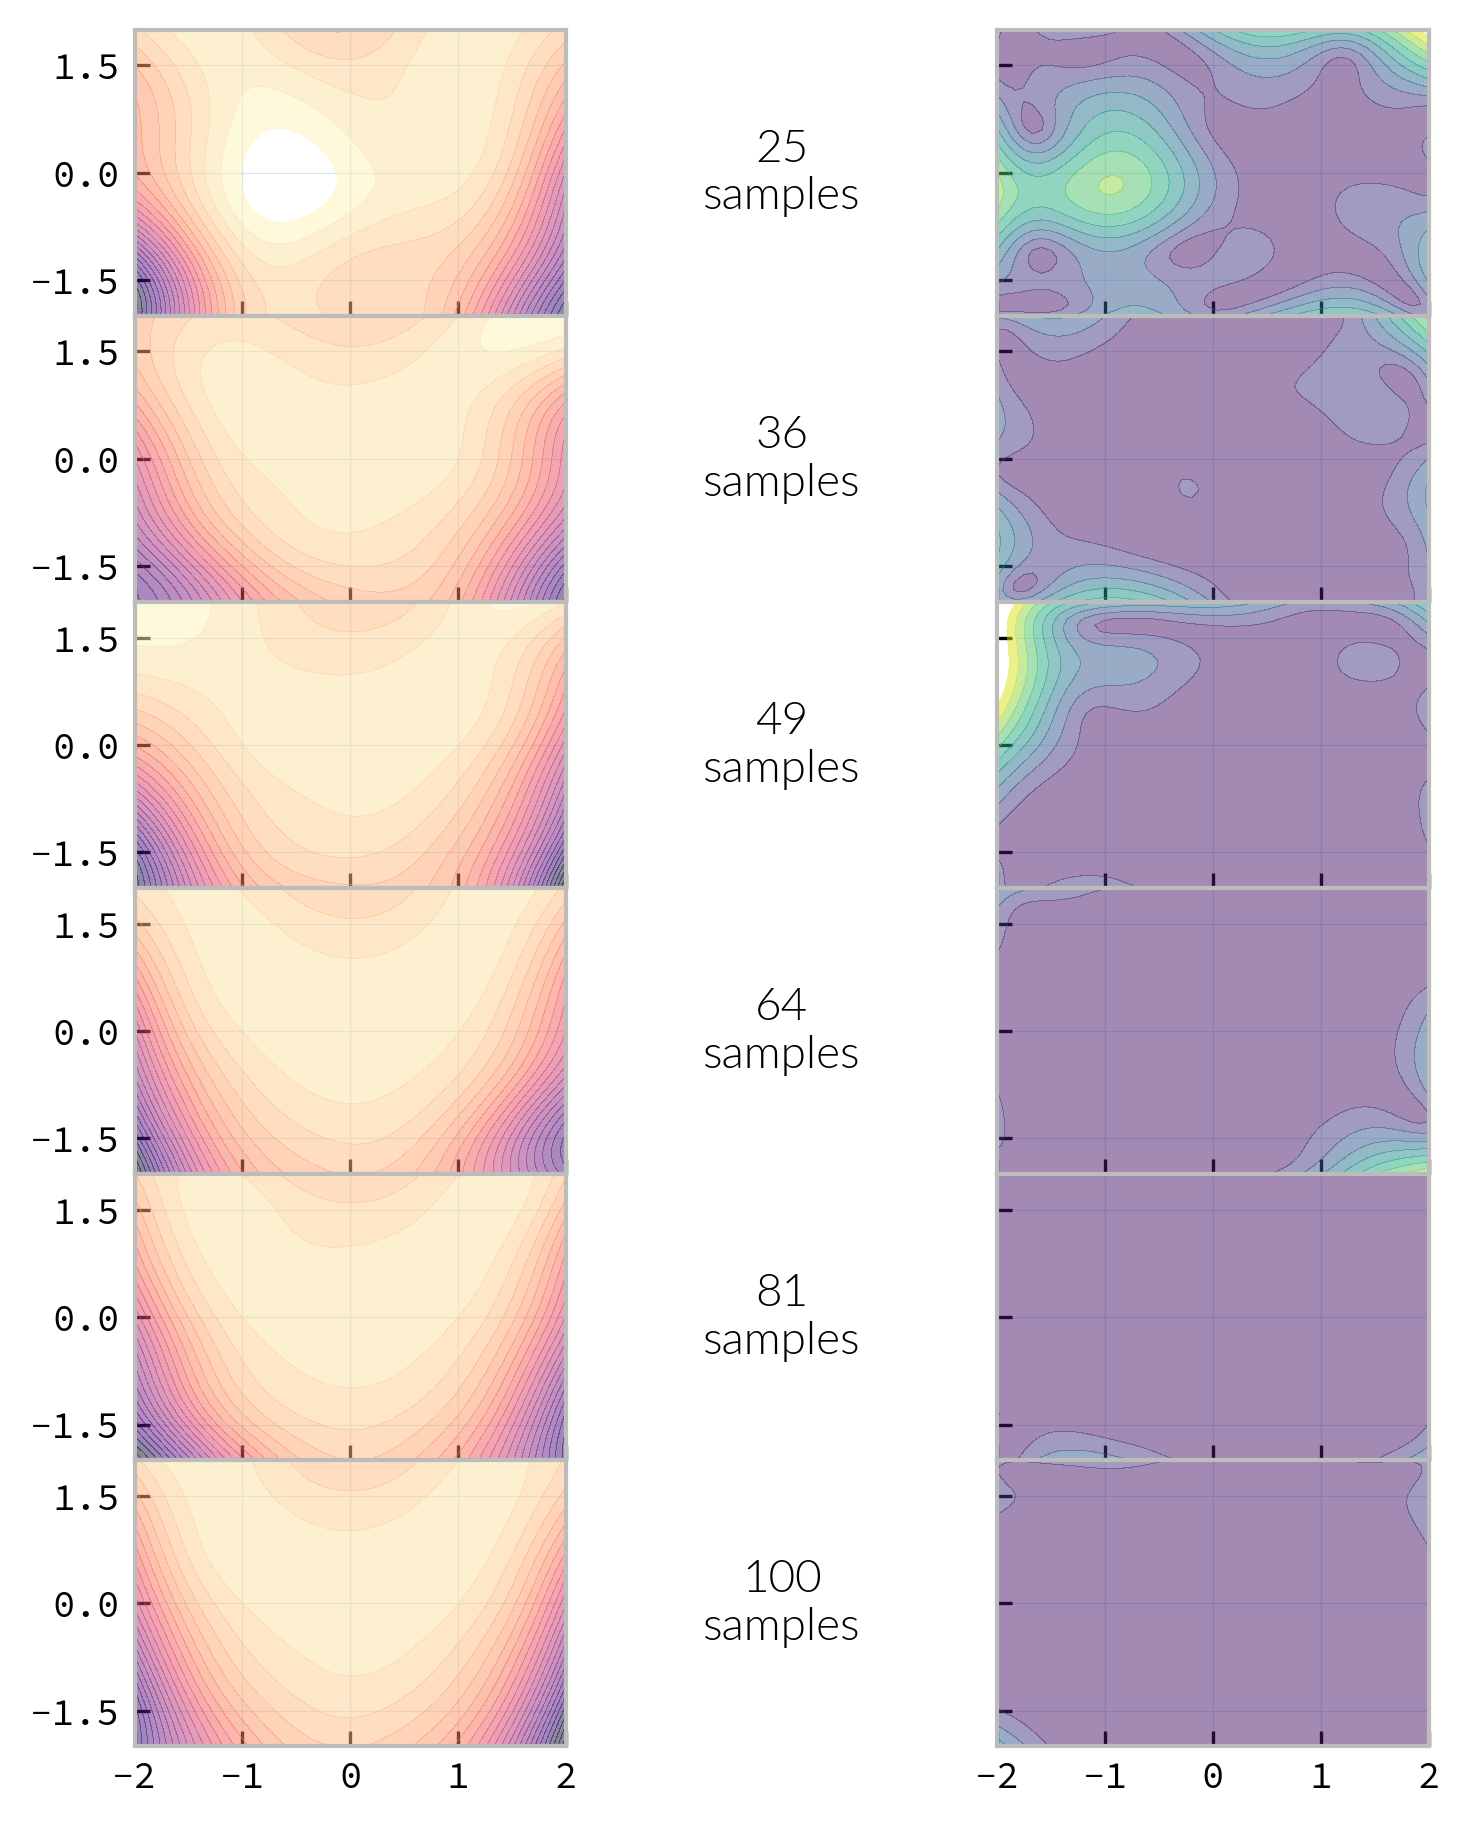

In [16]:
f, ax = plt.subplots(len(mus_random),3, dpi=300, sharex=True, sharey=True)
for i, [mu, sd] in enumerate(zip(mus_random, std_random)):
    ax[i, 0].contourf(x, y, mu.reshape(50,50), levels=np.arange(-200, 3610, 150), alpha=0.5)
    ax[i, 0].set_yticks([-1.5, 0, 1.5])
    ax[i, 2].contourf(x, y, sd.reshape(50,50), levels=np.arange(0, 10, 1), alpha=0.5, cmap="viridis")
    ax[i, 1].axis('off')
    ax[i, 1].text(0, 0, "{}\nsamples".format((5+i)**2), ha="center", va="center", fontdict=thesis.lato)
f = thesis.thesisify(f, height=2)
f.subplots_adjust(wspace=0, hspace=0)
f.savefig("../../figures/gp/rosen-random-progress.pdf")

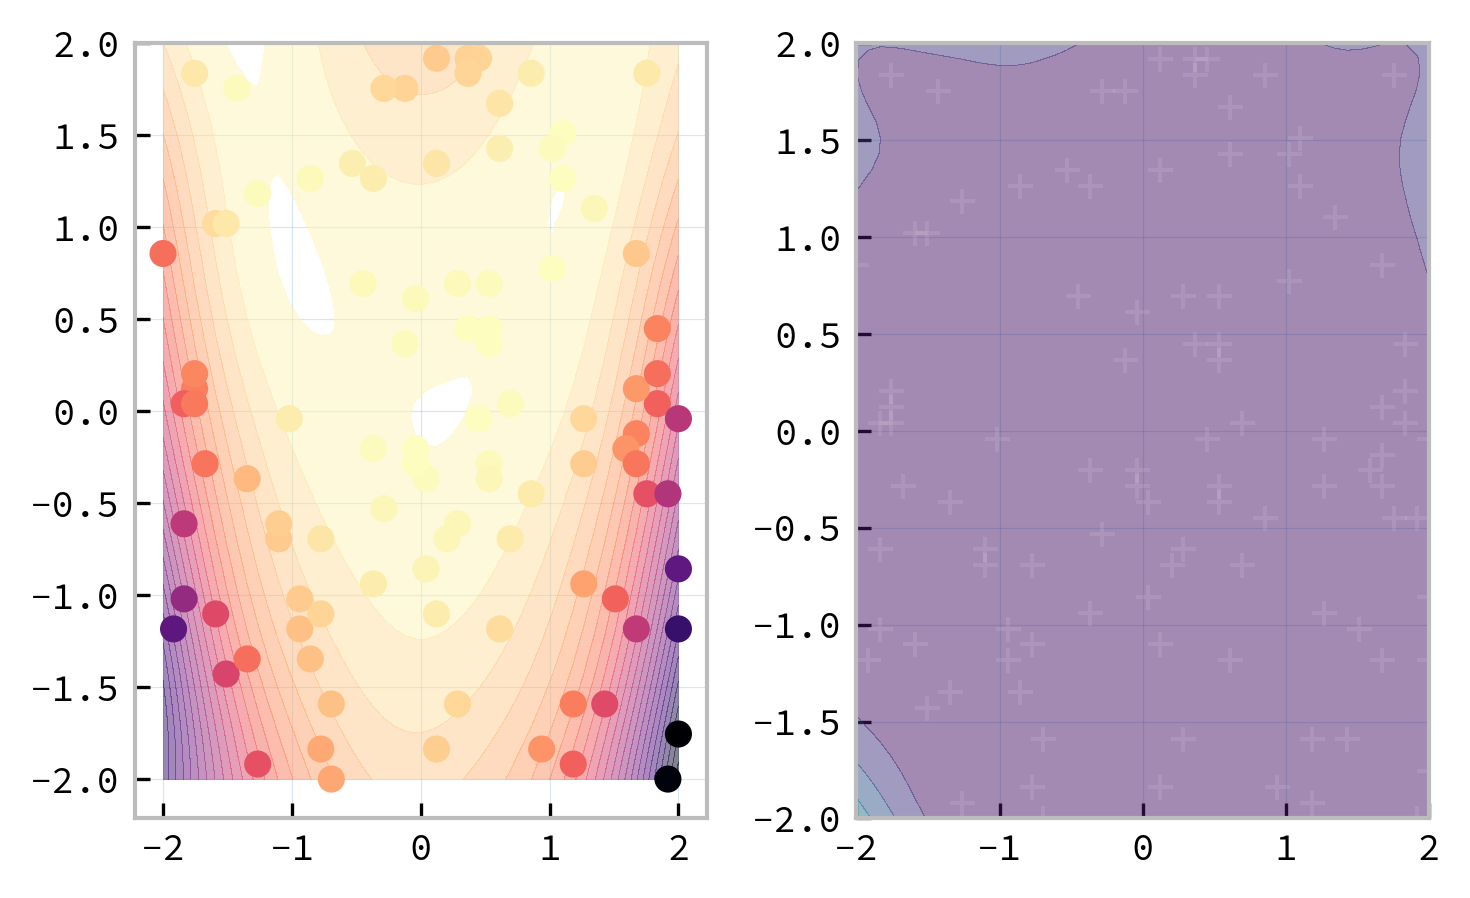

In [17]:
f, ax = plt.subplots(1,2, dpi=300)
ax[0].contourf(x, y, mu.reshape(50,50), levels=np.arange(0, 3610, 150), zorder=1, alpha=0.5)
ax[0].grid(which="both", zorder=99)

ax[0].scatter(xy[choice, 0], xy[choice, 1], c=rosen[choice])

ax[1].contourf(x, y, sd.reshape(50,50), levels=np.arange(0, 10, 1), zorder=1, alpha=0.5, cmap='viridis')
ax[1].grid(which="both", zorder=99)

ax[1].plot(xy[choice, 0], xy[choice, 1], '+', alpha=0.1, color='white')
f = thesis.thesisify(f);

Let's take a slightly more rational approach to selecting the initial data.

First, a full factorial sampling plan, which represents an evenly sampled grid.

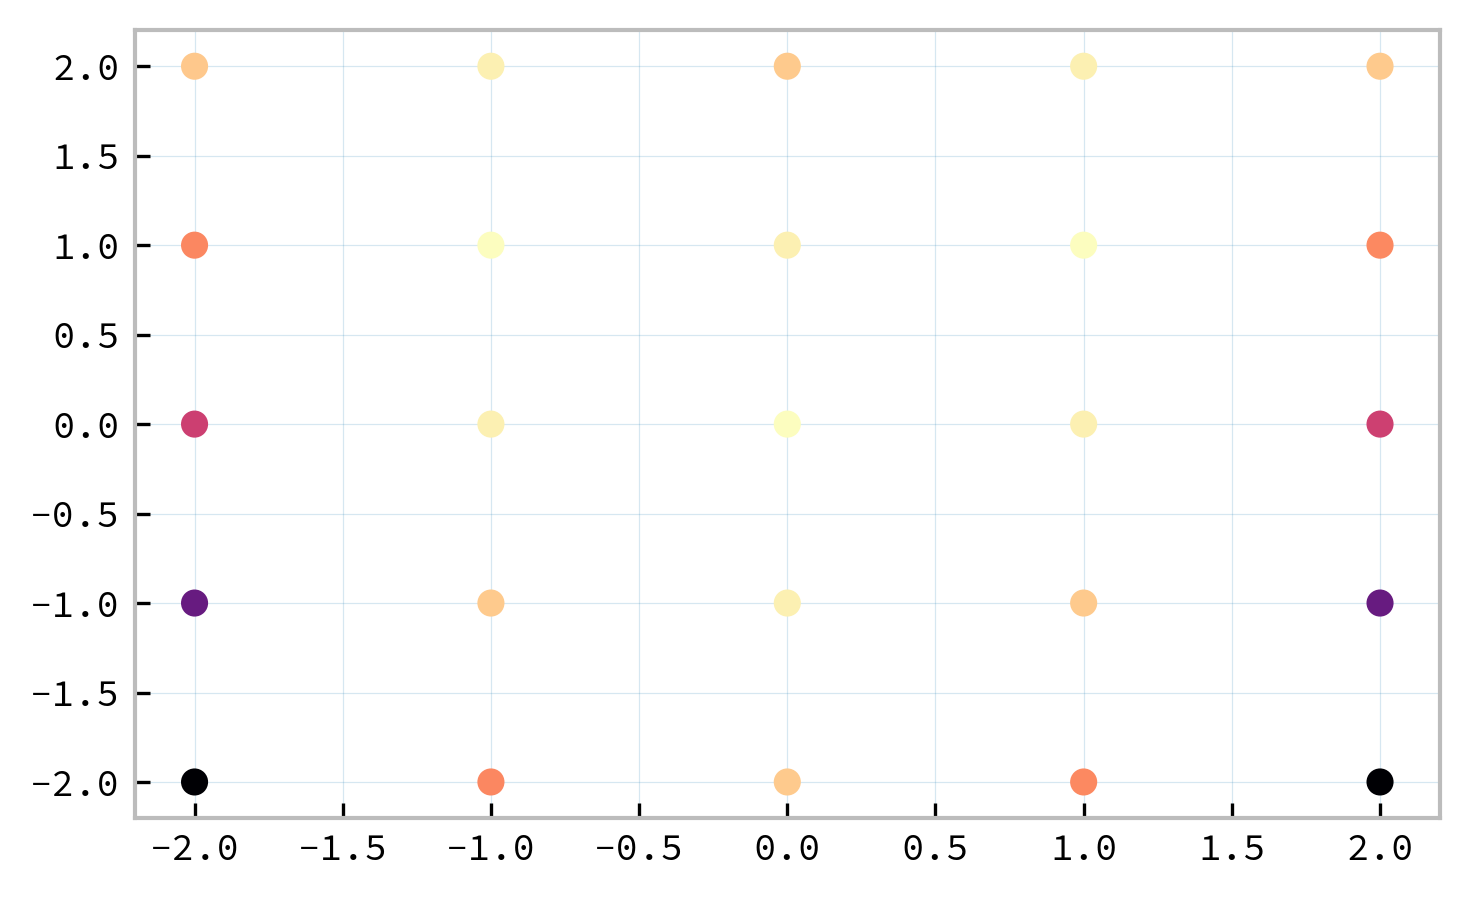

In [18]:
x = np.linspace(-2,2, 5)
y = np.linspace(-2,2, 5)
xy = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
rosen = np.array([rosen_function(xx) for xx in xy])

f, ax = plt.subplots(1,1, dpi=300)
ax.scatter(xy[:,0], xy[:, 1], c=rosen)
ax.grid(which="both", zorder=99)
f = thesis.thesisify(f);

In [19]:
x = np.linspace(-2,2, 5)
y = np.linspace(-2,2, 5)
xy = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
rosen = np.array([rosen_function(xx) for xx in xy])

with pm.Model() as model:

    amp = pm.Normal("amplitude", 1, 1)
    ls = [0.012, 0.012] #
    ls = pm.Normal("metric", mu=[.1, .1], sd=1, shape=2) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
    #ls = pm.Gamma("metric", alpha=.03, beta=0.015, shape=2)
    #period = pm.Gamma("period", alpha=1, beta=0.5)
    alpha = pm.Gamma("alpha", alpha=5, beta=.5, shape=1)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.ExpQuad(2, ls=[1, 1]) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=xy, y=rosen, noise=sigma)

    mp = pm.find_MAP()

x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)
xy_pred = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
with model:
    mu, var = gp.predict(xy_pred, point=mp, diag=True)
    sd = np.sqrt(var)

logp = -1.6412e+05, ||grad|| = 1,580.5: 100%|██████████| 29/29 [00:00<00:00, 457.23it/s]     


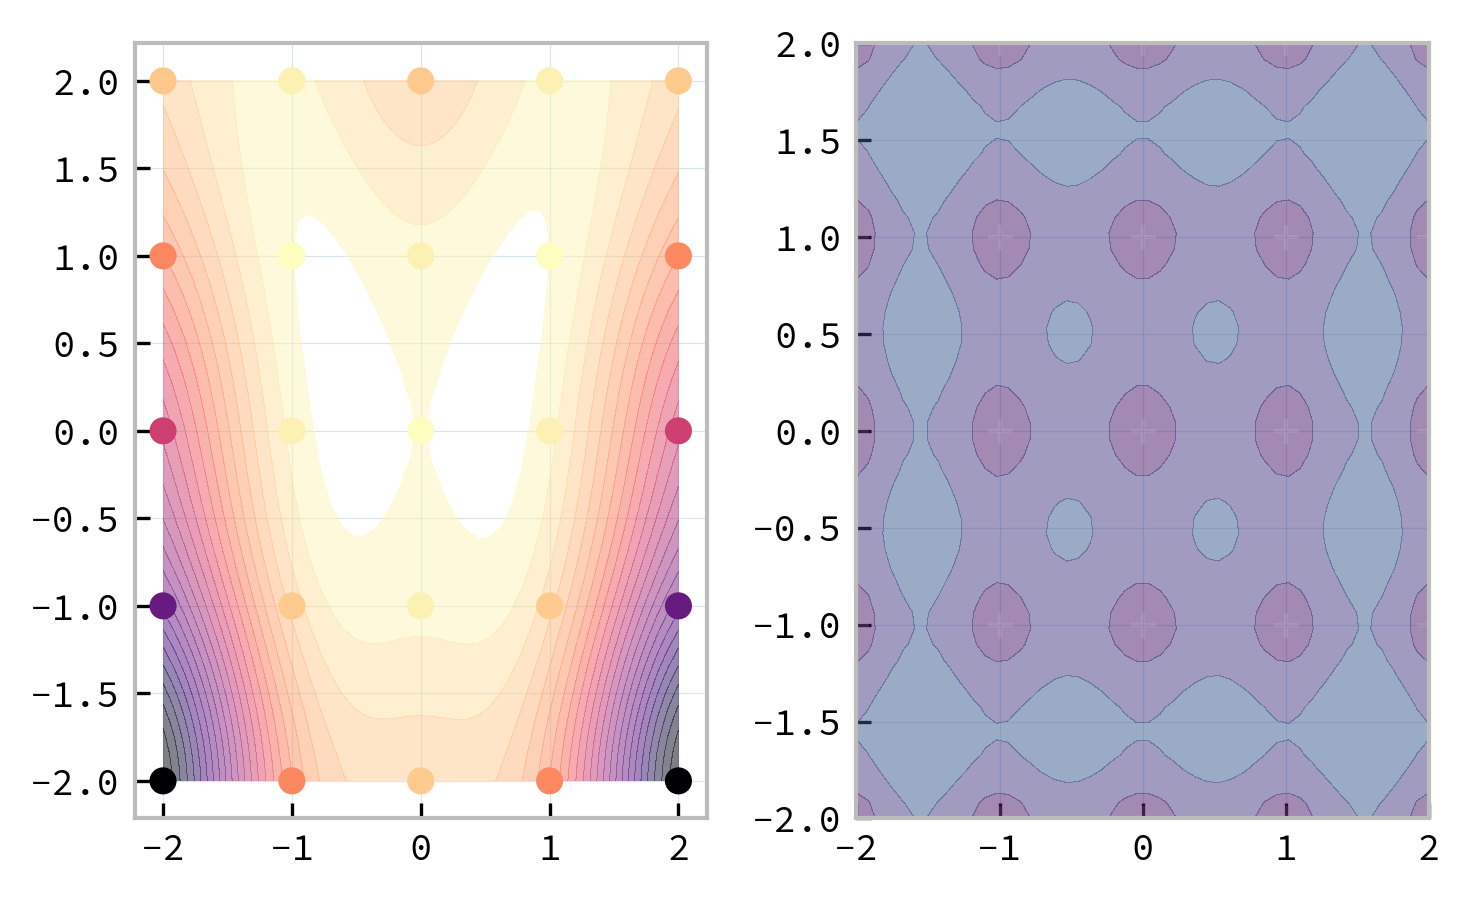

In [20]:
f, ax = plt.subplots(1,2, dpi=300)
ax[0].contourf(x, y, mu.reshape(50,50), levels=np.arange(0, 3610, 150), zorder=1, alpha=0.5)
ax[0].grid(which="both", zorder=99)

ax[0].scatter(xy[:, 0], xy[:, 1], c=rosen)

ax[1].contourf(x, y, sd.reshape(50,50), levels=np.arange(0, 10, 1), zorder=1, alpha=0.5, cmap='viridis')
ax[1].grid(which="both", zorder=99)

ax[1].plot(xy[:, 0], xy[:, 1], '+', alpha=0.1, color='white')
f = thesis.thesisify(f);

In [21]:
rmses_factorial = []

mus_factorial = []
std_factorial = []

np.random.seed(300)

x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)
xy_pred = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
rosen_pred_locs = np.array([rosen_function(xx) for xx in xy_pred])

for samples in np.arange(5, 11, 1)**2:
    
    x = np.linspace(-2,2, int(np.sqrt(samples)))
    y = np.linspace(-2,2, int(np.sqrt(samples)))
    xy = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    rosen_fac = np.array([rosen_function(xx) for xx in xy])

    with pm.Model() as model:
    
        amp = pm.Normal("amplitude", 1, 1)
        ls = [0.012, 0.012] #
        ls = pm.Normal("metric", mu=[.1, .1], sd=1, shape=2) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
        #ls = pm.Gamma("metric", alpha=.03, beta=0.015, shape=2)
        #period = pm.Gamma("period", alpha=1, beta=0.5)
        alpha = pm.Gamma("alpha", alpha=5, beta=.5, shape=1)
        # Specify the covariance function.
        cov_func = amp * pm.gp.cov.ExpQuad(2, ls=[1, 1]) #+ pm.gp.cov.WhiteNoise(1)

        # Specify the GP.  The default mean function is `Zero`.
        gp = pm.gp.Marginal(cov_func=cov_func)

        # 
        sigma = pm.Normal("sigma", 0.1, 0.001)
        y_ = gp.marginal_likelihood("y", X=xy, y=rosen_fac, noise=sigma)
        
        mp = pm.find_MAP()

    with model:
        mu, var = gp.predict(xy_pred, point=mp, diag=True)
        sd = np.sqrt(var)
        
    rmses_factorial.append(rmse(reality, mu))
    
    mus_factorial.append(mu)
    std_factorial.append(sd)

logp = -1.6412e+05, ||grad|| = 1,580.5: 100%|██████████| 29/29 [00:00<00:00, 459.60it/s]     
logp = -1.3249e+05, ||grad|| = 77.716: 100%|██████████| 38/38 [00:00<00:00, 592.58it/s]      
logp = -2.5774e+05, ||grad|| = 15,510: 100%|██████████| 29/29 [00:00<00:00, 228.92it/s]     
logp = -3.0711e+05, ||grad|| = 58,983: 100%|██████████| 30/30 [00:00<00:00, 406.37it/s]     
logp = -2.9243e+05, ||grad|| = 33,256: 100%|██████████| 29/29 [00:00<00:00, 162.91it/s]      
logp = -3.2077e+05, ||grad|| = 13,275: 100%|██████████| 29/29 [00:00<00:00, 162.48it/s]      


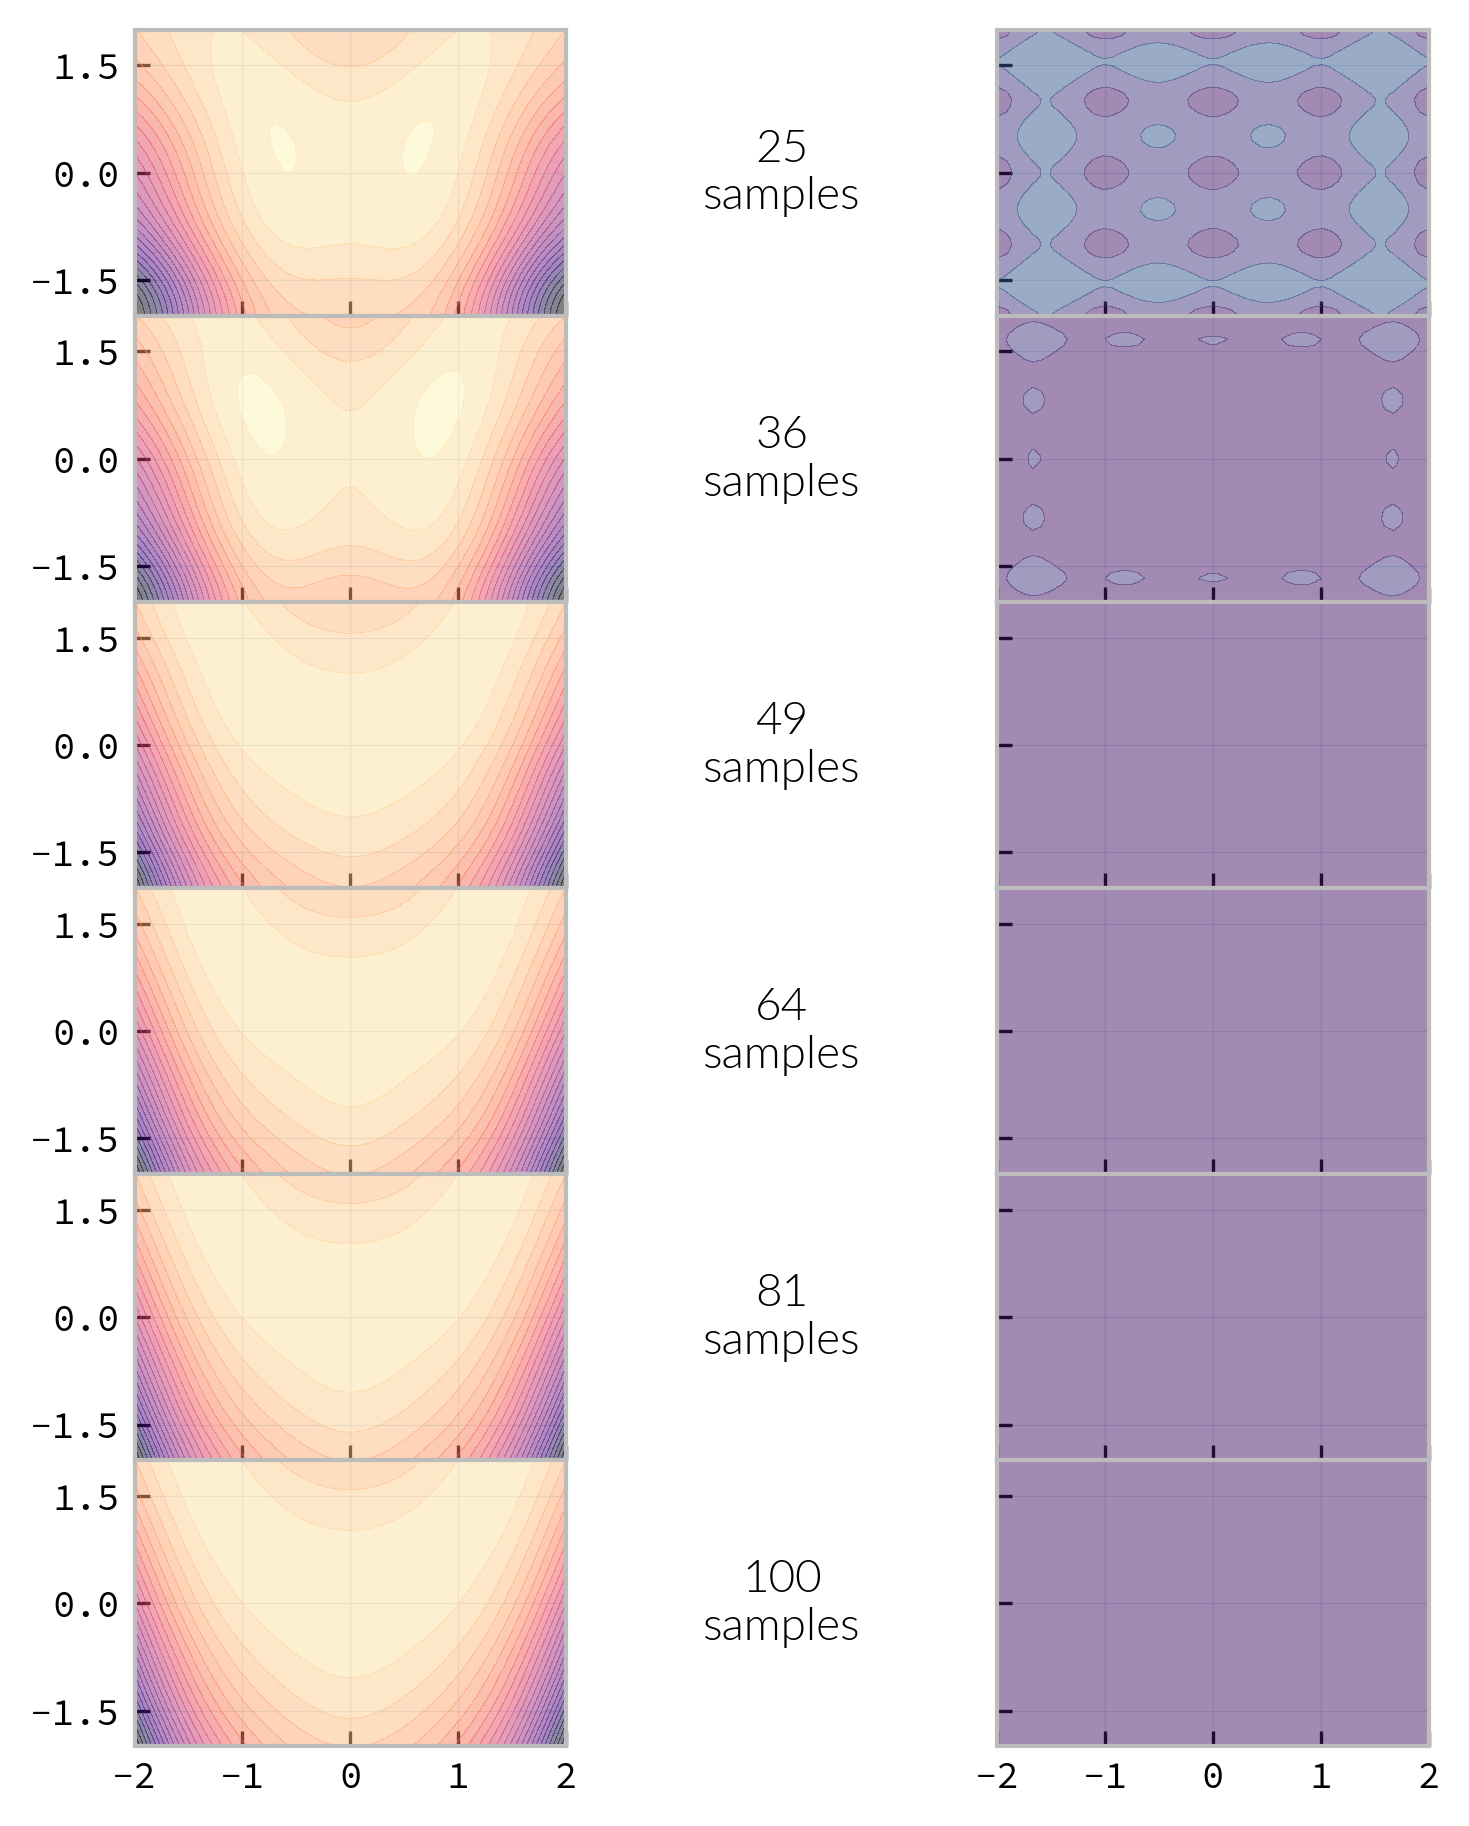

In [22]:
x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)
f, ax = plt.subplots(len(mus_factorial),3, dpi=300, sharex=True, sharey=True)
for i, [mu, sd] in enumerate(zip(mus_factorial, std_factorial)):
    ax[i, 0].contourf(x, y, mu.reshape(50,50), levels=np.arange(-200, 3610, 150), alpha=0.5)
    ax[i, 0].set_yticks([-1.5, 0, 1.5])
    ax[i, 2].contourf(x, y, sd.reshape(50,50), levels=np.arange(0, 10, 1), alpha=0.5, cmap="viridis")
    ax[i, 1].axis('off')
    ax[i, 1].text(0, 0, "{}\nsamples".format((5+i)**2), ha="center", va="center", fontdict=thesis.lato)
f = thesis.thesisify(f, height=2)
f.subplots_adjust(wspace=0, hspace=0)
f.savefig("../../figures/gp/rosen-factorial-progress.pdf")

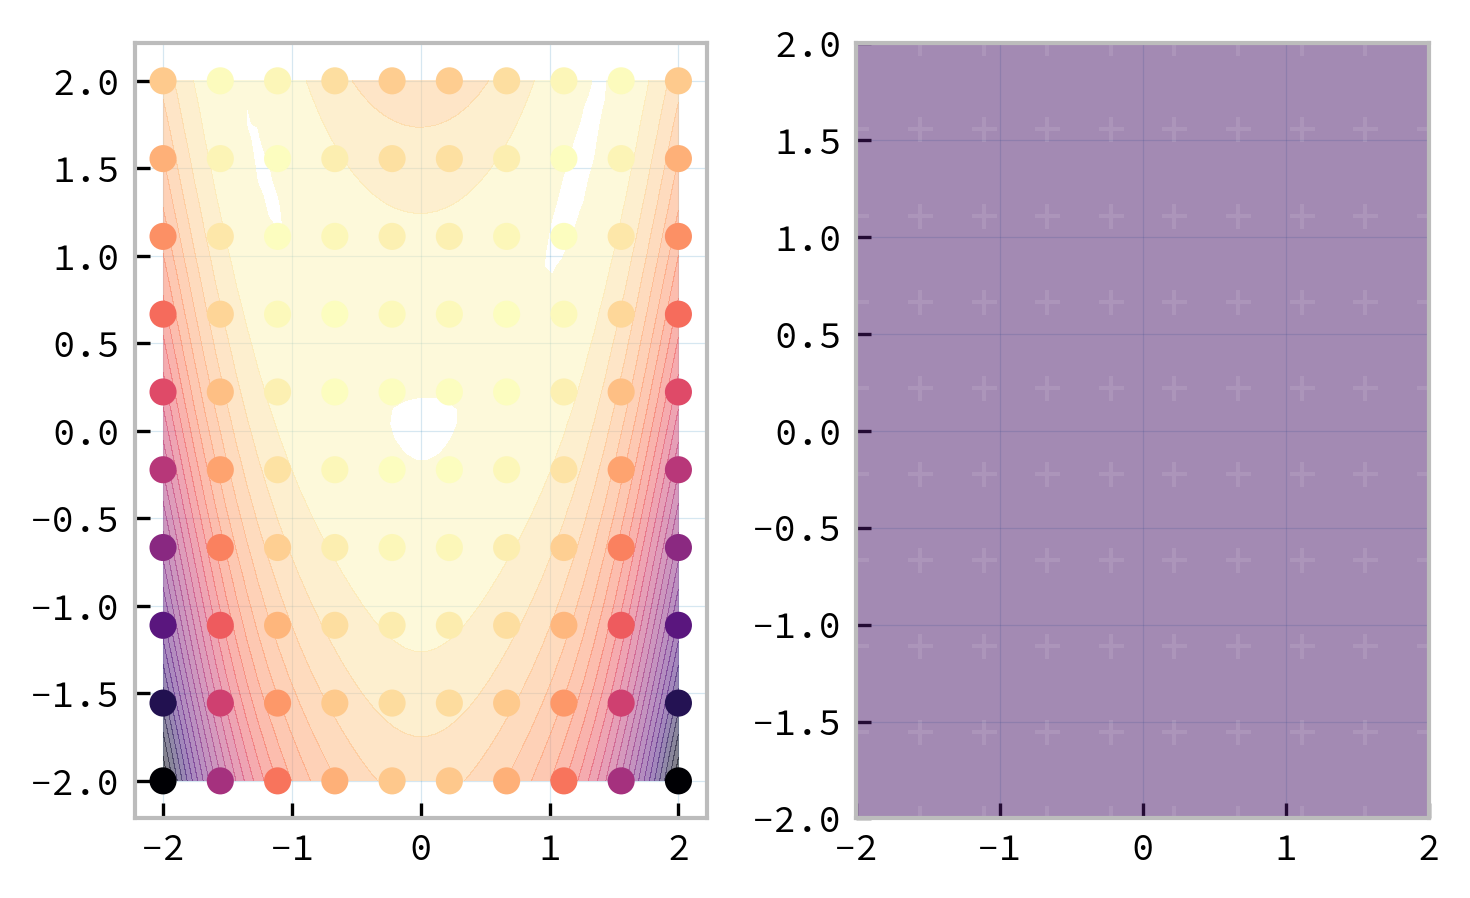

In [23]:
x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)

f, ax = plt.subplots(1,2, dpi=300)
ax[0].contourf(x, y, mu.reshape(50,50), levels=np.arange(0, 3610, 150), zorder=1, alpha=0.5)
ax[0].grid(which="both", zorder=99)

ax[0].scatter(xy[:, 0], xy[:, 1], c=rosen_fac)

ax[1].contourf(x, y, sd.reshape(50,50), levels=np.arange(0, 10, 1), zorder=1, alpha=0.5, cmap='viridis')
ax[1].grid(which="both", zorder=99)

ax[1].plot(xy[:, 0], xy[:, 1], '+', alpha=0.1, color='white')
f = thesis.thesisify(f);

In [25]:
!pip install pydoe

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7.
  Stored in directory: /home/daniel/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pydoe


In [26]:
from pyDOE import lhs

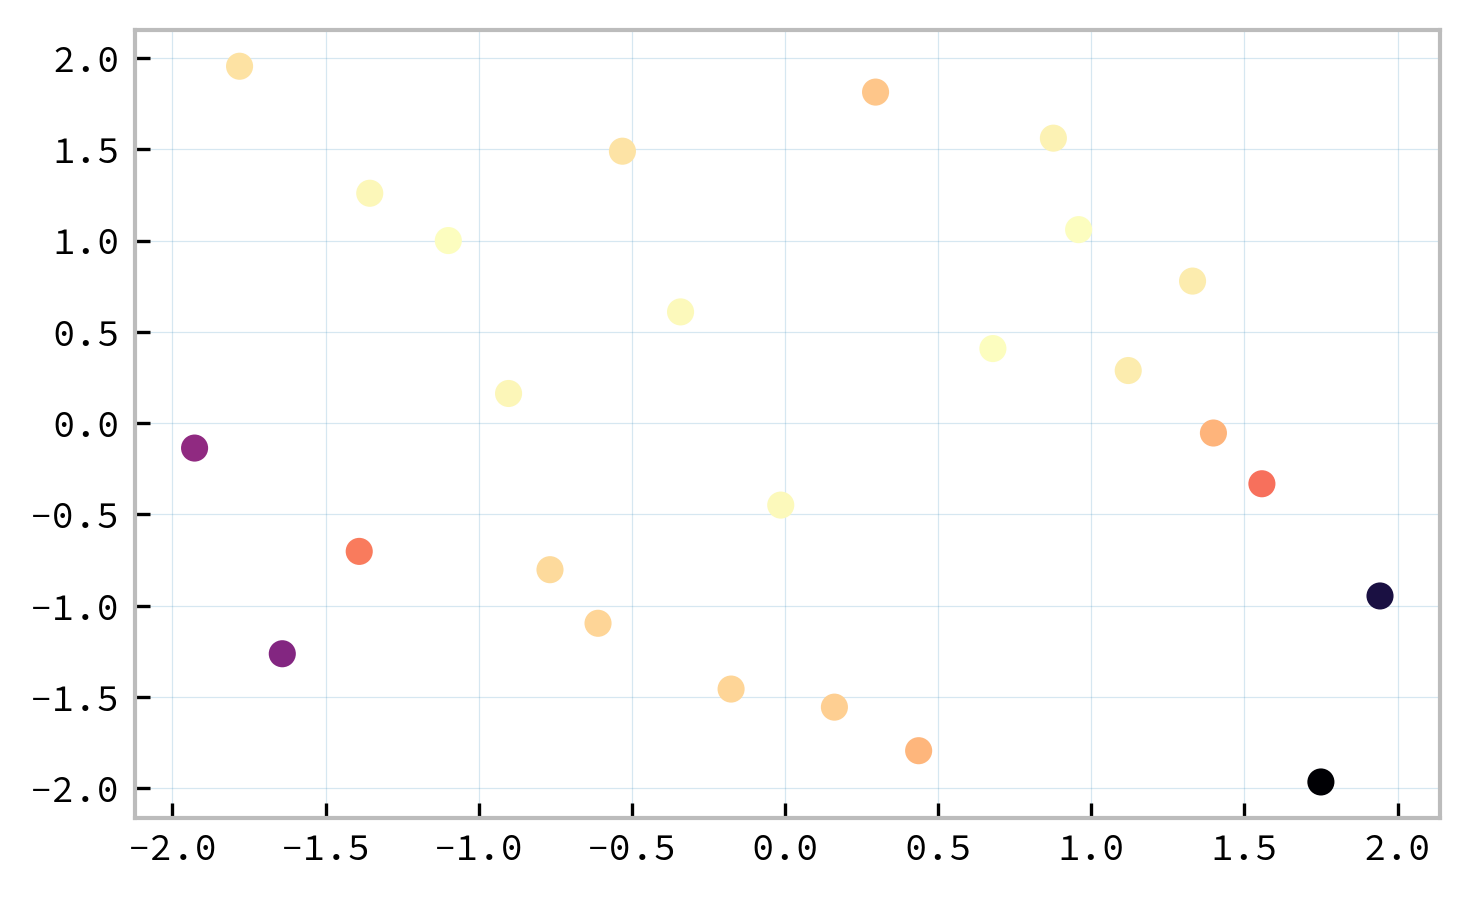

In [27]:
x = np.linspace(-2,2, 5)
y = np.linspace(-2,2, 5)
xy = lhs(2, samples=25) * 4 - 2
rosen_latin = np.array([rosen_function(xx) for xx in xy])

f, ax = plt.subplots(1,1, dpi=300)
ax.scatter(xy[:,0], xy[:, 1], c=rosen_latin)
ax.grid(which="both", zorder=99)
f = thesis.thesisify(f);

In [28]:
with pm.Model() as model:

    amp = pm.Normal("amplitude", 1, 1)
    ls = [0.012, 0.012] #
    ls = pm.Normal("metric", mu=[.1, .1], sd=1, shape=2) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
    #ls = pm.Gamma("metric", alpha=.03, beta=0.015, shape=2)
    #period = pm.Gamma("period", alpha=1, beta=0.5)
    alpha = pm.Gamma("alpha", alpha=5, beta=.5, shape=1)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.ExpQuad(2, ls=[1, 1]) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=xy, y=rosen_latin, noise=sigma)

    mp = pm.find_MAP()

x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)
xy_pred = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
with model:
    mu, var = gp.predict(xy_pred, point=mp, diag=True)
    sd = np.sqrt(var)

logp = -86,889, ||grad|| = 16,900: 100%|██████████| 28/28 [00:00<00:00, 444.68it/s]      


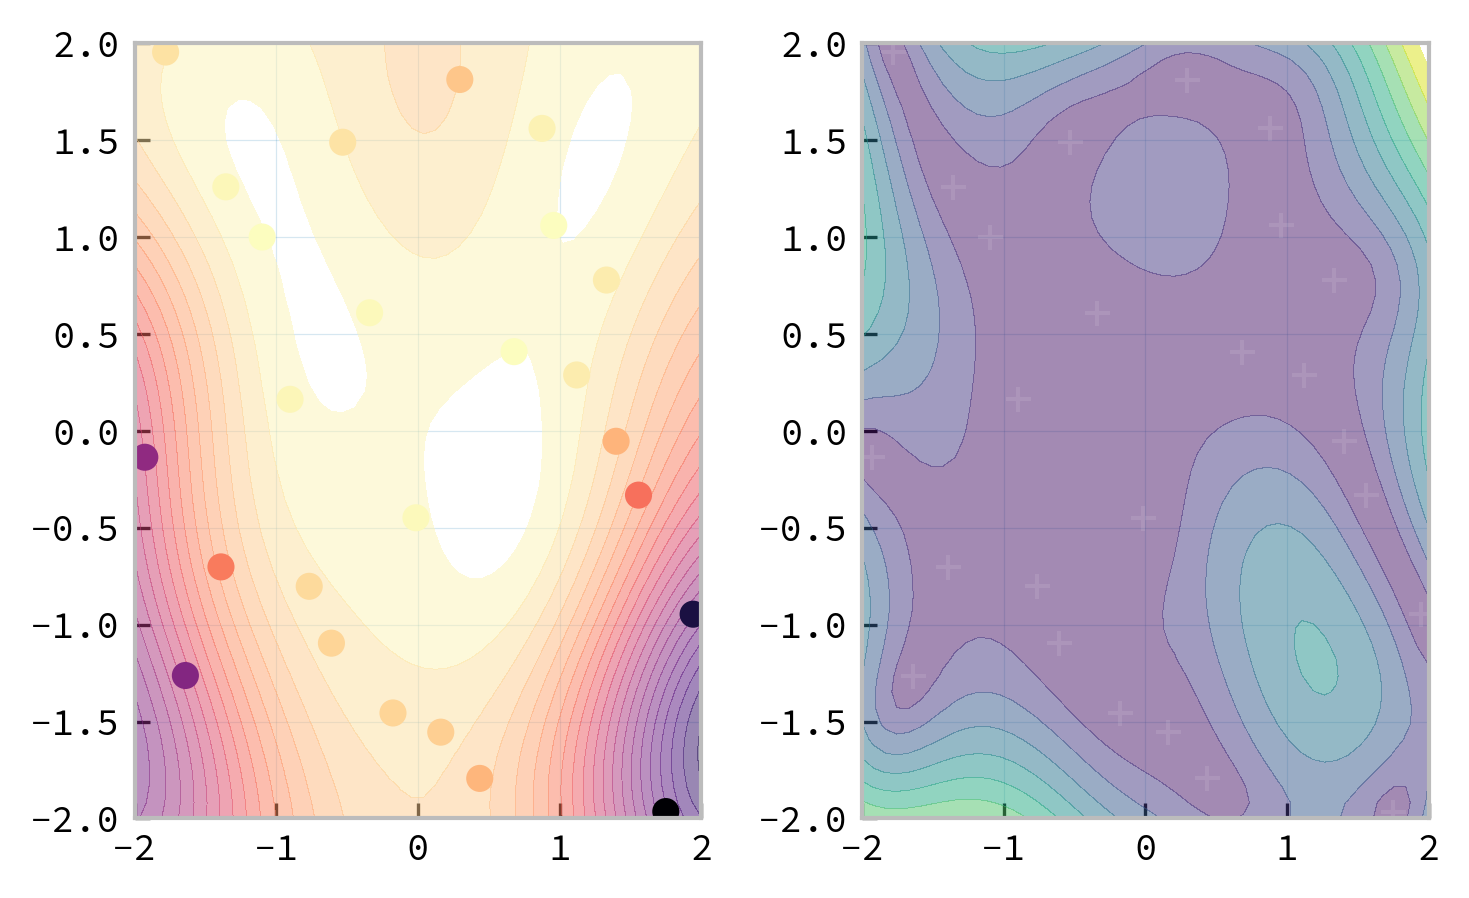

In [29]:
f, ax = plt.subplots(1,2, dpi=300)
ax[0].contourf(x, y, mu.reshape(50,50), levels=np.arange(0, 3610, 150), zorder=1, alpha=0.5)
ax[0].grid(which="both", zorder=99)

ax[0].scatter(xy[:, 0], xy[:, 1], c=rosen_latin)

ax[1].contourf(x, y, sd.reshape(50,50), levels=np.arange(0, 10, 1), zorder=1, alpha=0.5, cmap='viridis')
ax[1].grid(which="both", zorder=99)

ax[1].plot(xy[:, 0], xy[:, 1], '+', alpha=0.1, color='white')
f = thesis.thesisify(f);

In [30]:
rmses_latin = []

mus_latin = []
std_latin = []

np.random.seed(300)

x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)
xy_pred = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
rosen_pred_locs = np.array([rosen_function(xx) for xx in xy_pred])

for samples in np.arange(5, 11, 1)**2:
    
    xy = lhs(2, samples=samples) * 4 - 2
    rosen_latin = np.array([rosen_function(xx) for xx in xy])

    with pm.Model() as model:
    
        amp = pm.Normal("amplitude", 1, 1)
        ls = [0.012, 0.012] #
        ls = pm.Normal("metric", mu=[.1, .1], sd=1, shape=2) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
        #ls = pm.Gamma("metric", alpha=.03, beta=0.015, shape=2)
        #period = pm.Gamma("period", alpha=1, beta=0.5)
        alpha = pm.Gamma("alpha", alpha=5, beta=.5, shape=1)
        # Specify the covariance function.
        cov_func = amp * pm.gp.cov.ExpQuad(2, ls=[1, 1]) #+ pm.gp.cov.WhiteNoise(1)

        # Specify the GP.  The default mean function is `Zero`.
        gp = pm.gp.Marginal(cov_func=cov_func)

        # 
        sigma = pm.Normal("sigma", 0.1, 0.001)
        y_ = gp.marginal_likelihood("y", X=xy, y=rosen_latin, noise=sigma)
        
        mp = pm.find_MAP()

    with model:
        mu, var = gp.predict(xy_pred, point=mp, diag=True)
        sd = np.sqrt(var)
        
    rmses_latin.append(rmse(reality, mu))
    mus_latin.append(mu)
    std_latin.append(sd)

logp = -86,889, ||grad|| = 16,900: 100%|██████████| 28/28 [00:00<00:00, 446.74it/s]      
logp = -1.3633e+05, ||grad|| = 44,003: 100%|██████████| 30/30 [00:00<00:00, 436.10it/s]  
logp = -1.5889e+05, ||grad|| = 24,971: 100%|██████████| 29/29 [00:00<00:00, 581.15it/s]      
logp = -1.7835e+05, ||grad|| = 34,050: 100%|██████████| 29/29 [00:00<00:00, 335.74it/s]     
logp = -2.1377e+05, ||grad|| = 64,416: 100%|██████████| 28/28 [00:00<00:00, 348.80it/s]      
logp = -2.0114e+05, ||grad|| = 1.7502: 100%|██████████| 32/32 [00:00<00:00, 93.27it/s]      


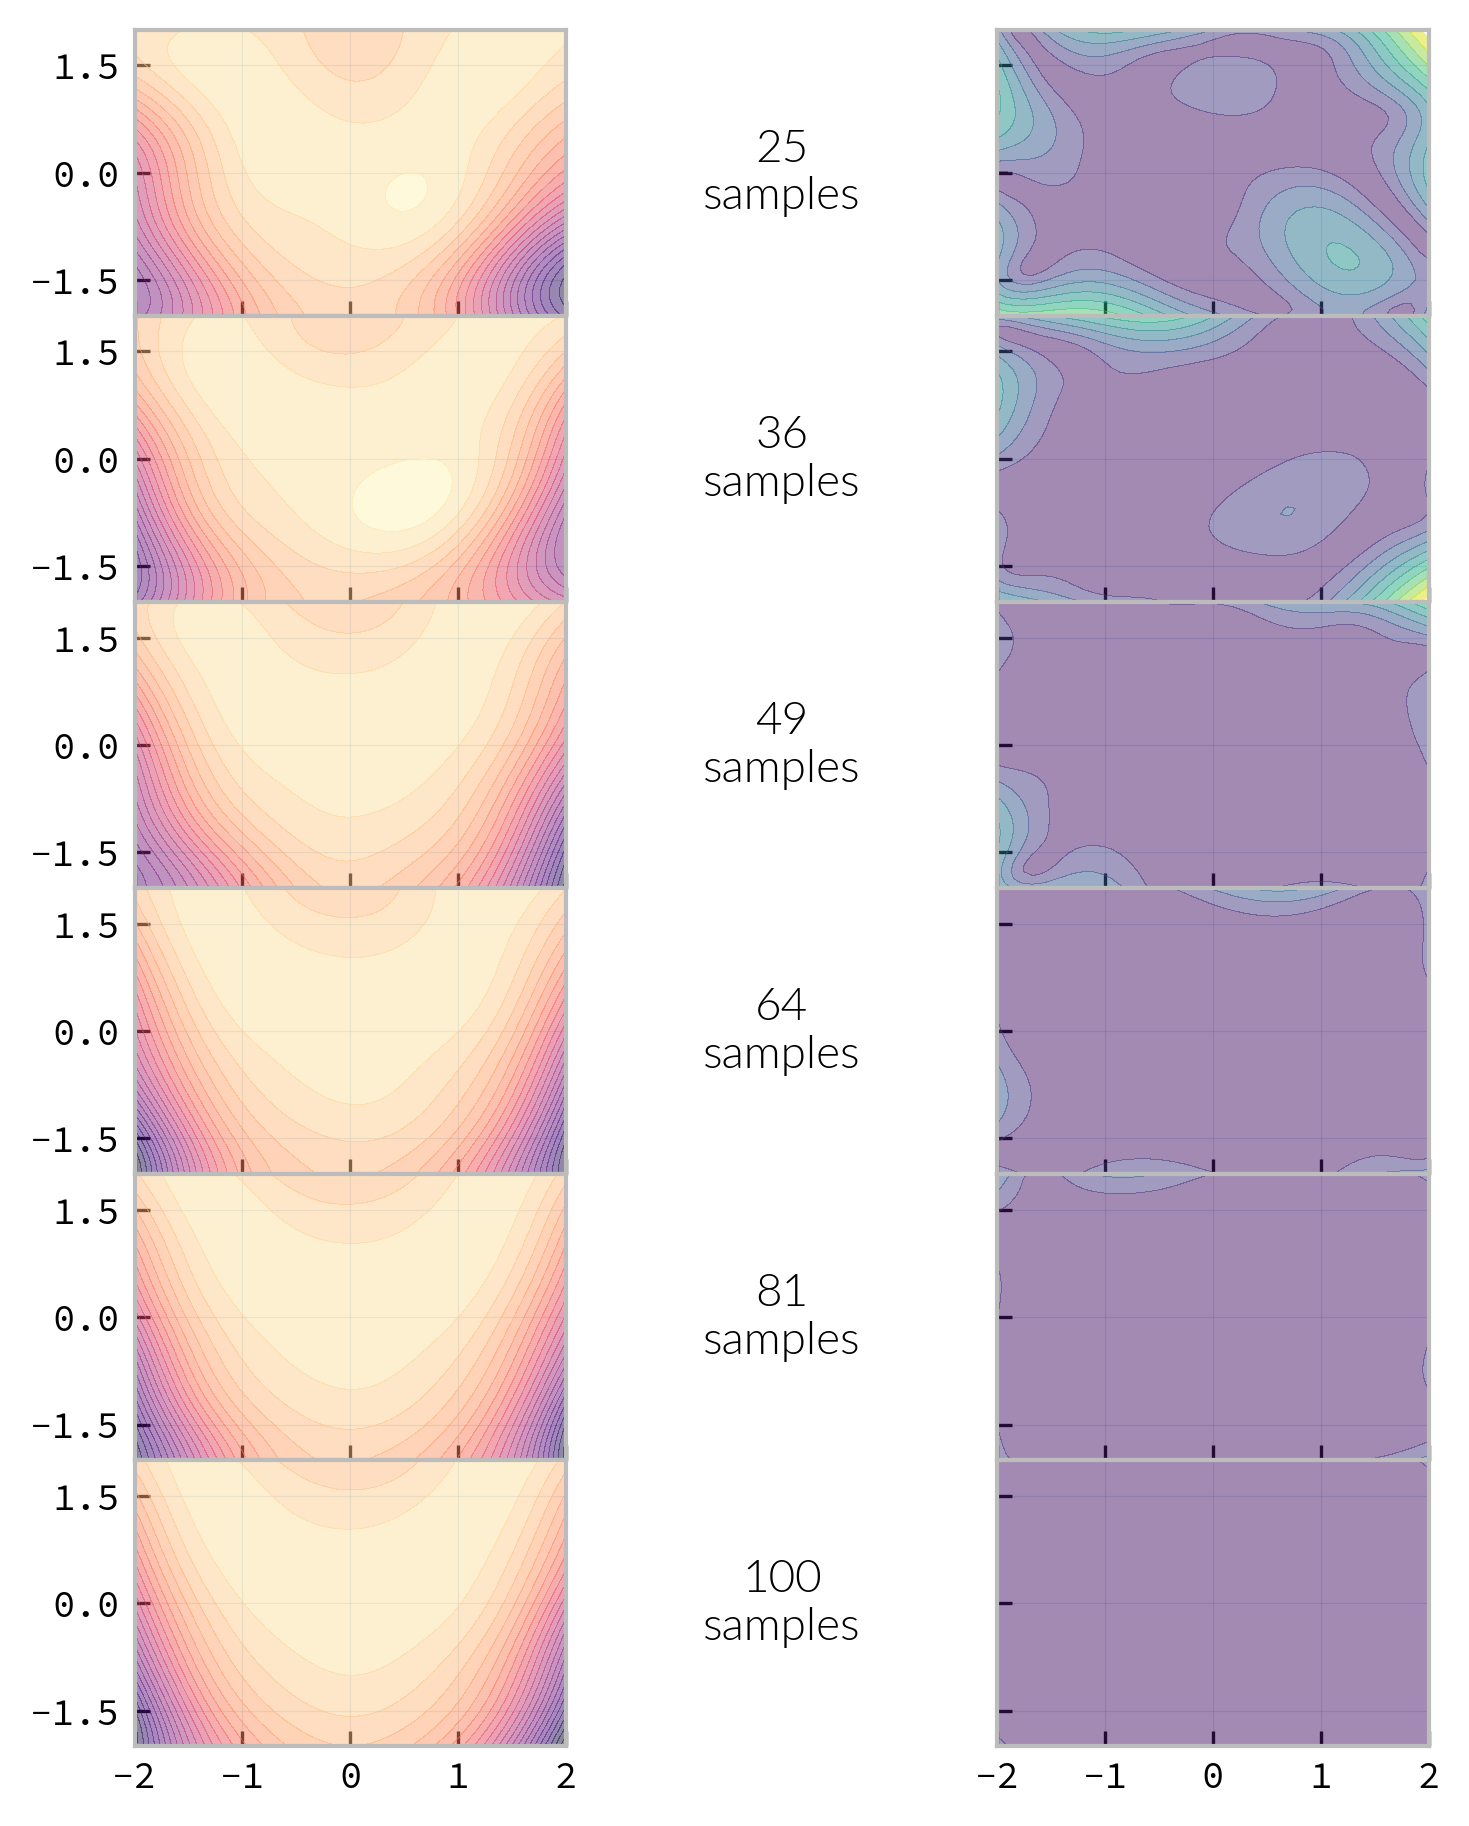

In [31]:
x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)
f, ax = plt.subplots(len(mus_latin),3, dpi=300, sharex=True, sharey=True)
for i, [mu, sd] in enumerate(zip(mus_latin, std_latin)):
    ax[i, 0].contourf(x, y, mu.reshape(50,50), levels=np.arange(-200, 3610, 150), alpha=0.5)
    ax[i, 0].set_yticks([-1.5, 0, 1.5])
    ax[i, 2].contourf(x, y, sd.reshape(50,50), levels=np.arange(0, 10, 1), alpha=0.5, cmap="viridis")
    ax[i, 1].axis('off')
    ax[i, 1].text(0, 0, "{}\nsamples".format((5+i)**2), ha="center", va="center", fontdict=thesis.lato)
thesis.thesisify(f, height=2)
f.subplots_adjust(wspace=0, hspace=0)
f = f.savefig("../../figures/gp/rosen-latin-progress.pdf")

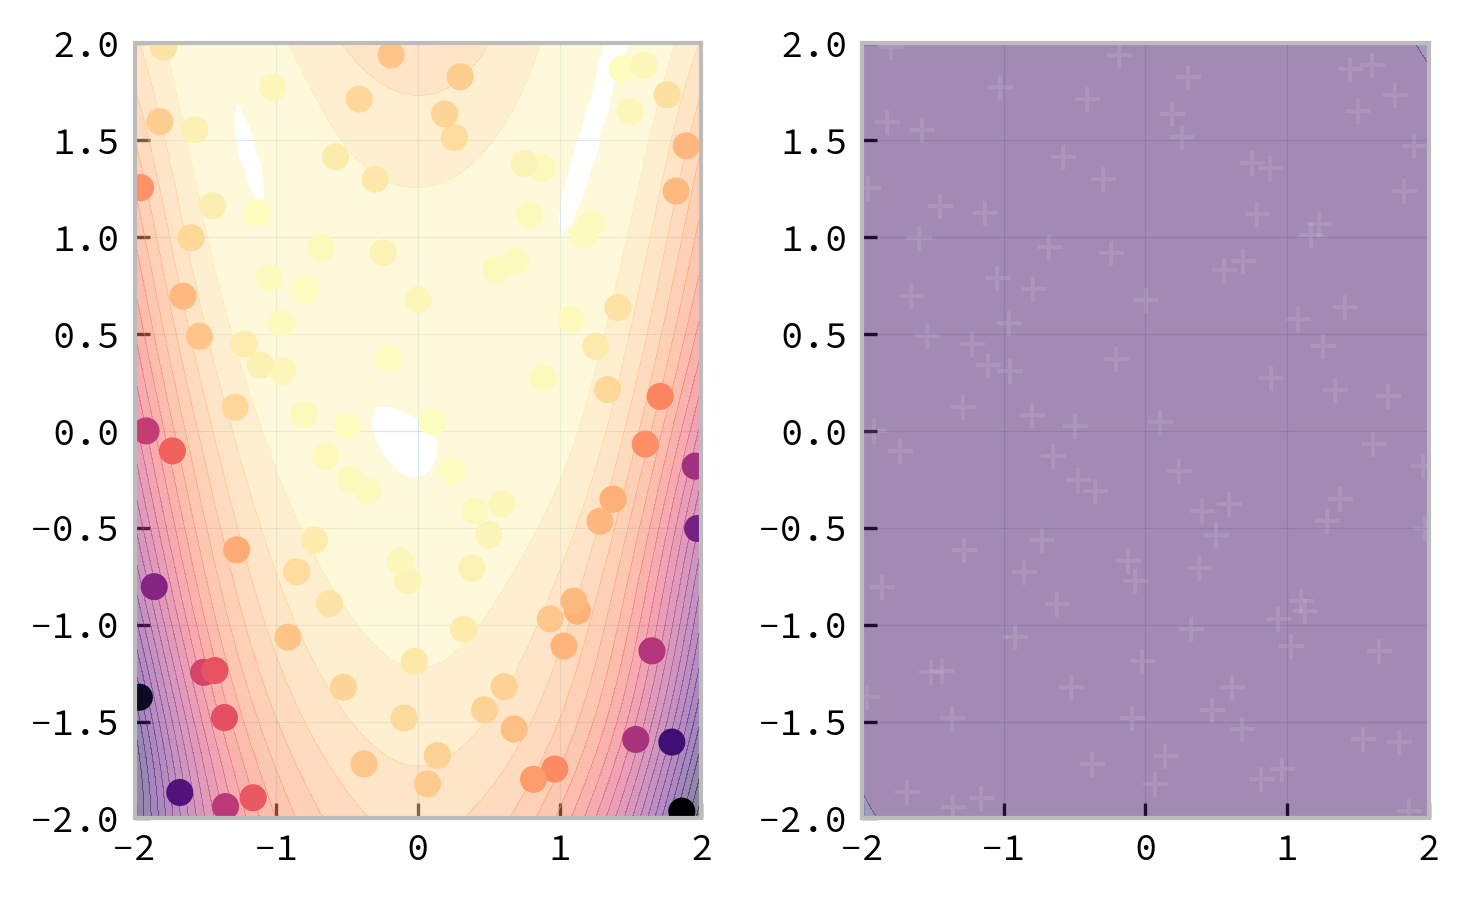

In [32]:
x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)

f, ax = plt.subplots(1,2, dpi=300)
ax[0].contourf(x, y, mu.reshape(50,50), levels=np.arange(0, 3610, 150), zorder=1, alpha=0.5)
ax[0].grid(which="both", zorder=99)

ax[0].scatter(xy[:, 0], xy[:, 1], c=rosen_latin)

ax[1].contourf(x, y, sd.reshape(50,50), levels=np.arange(0, 10, 1), zorder=1, alpha=0.5, cmap='viridis')
ax[1].grid(which="both", zorder=99)

ax[1].plot(xy[:, 0], xy[:, 1], '+', alpha=0.1, color='white')
f = thesis.thesisify(f);

ValueError: x and y must have same first dimension, but have shapes (10,) and (6,)

/home/daniel/.virtualenvs/aries/thesis2/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u"'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


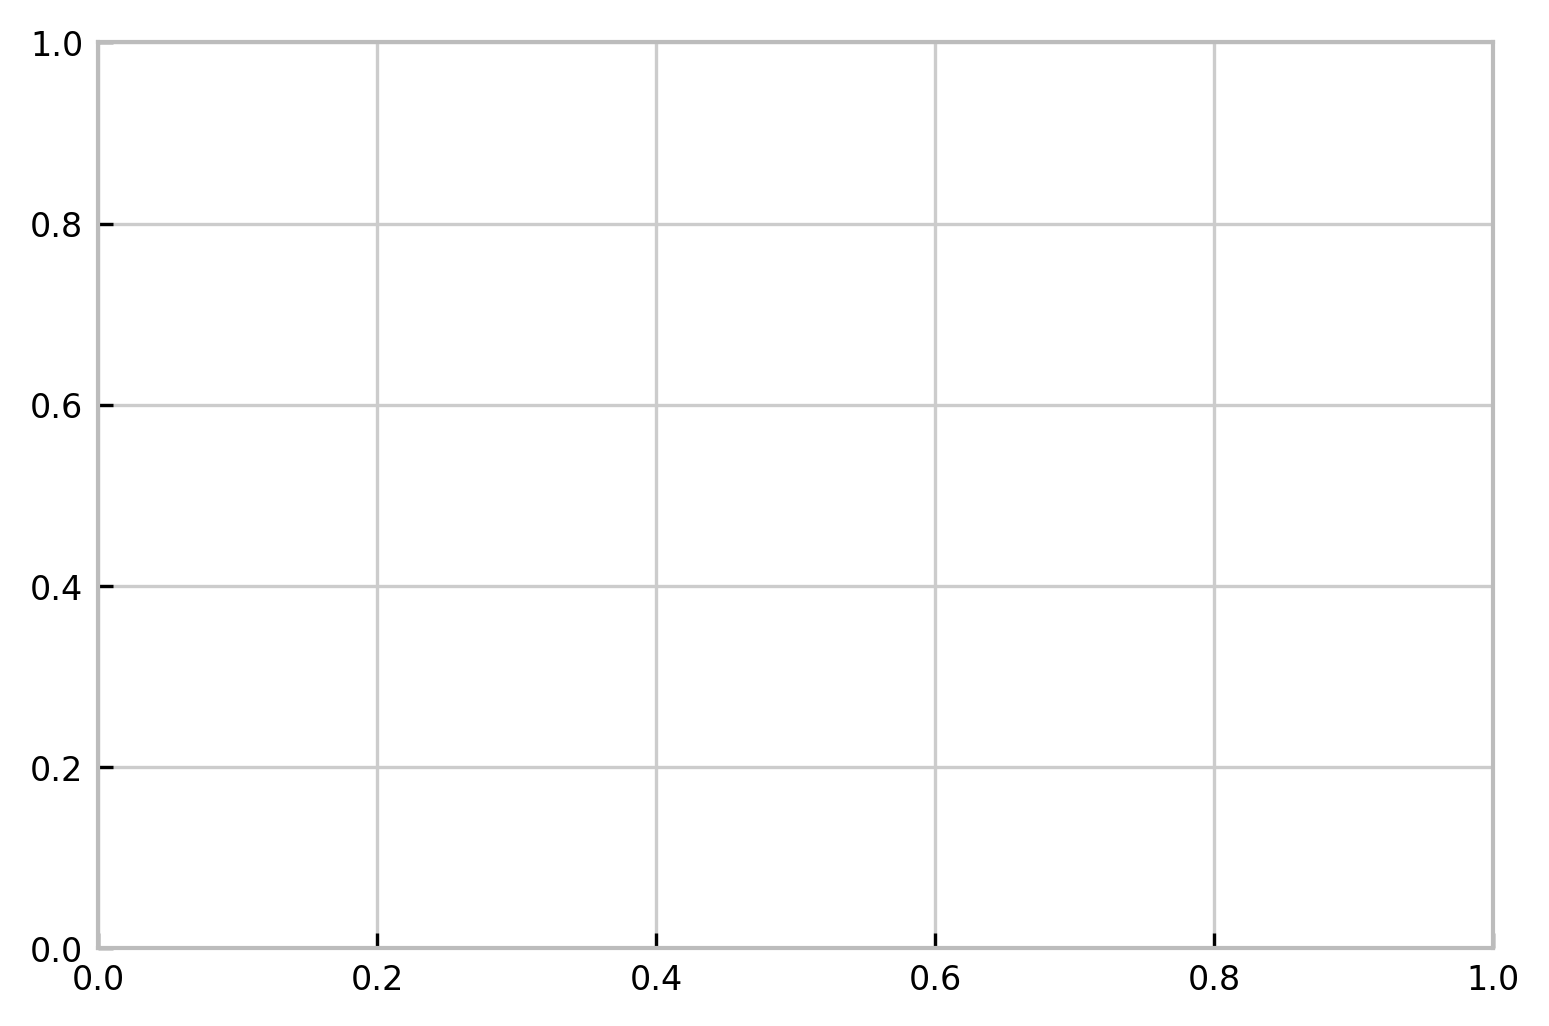

In [33]:
f, ax = plt.subplots(1,1, dpi=300)
ax.plot(np.arange(5, 15, 1)**2, rmses_latin, label="Latin hypercubes")

ax.plot(np.arange(5, 15, 1)**2, rmses_factorial, label="Full factorial")
ax.plot(np.arange(30,300,10), rmses, label="Stochastic")

ax.legend()

f.tight_layout()

f = thesis.thesisify(f);

# Infill sampling methods

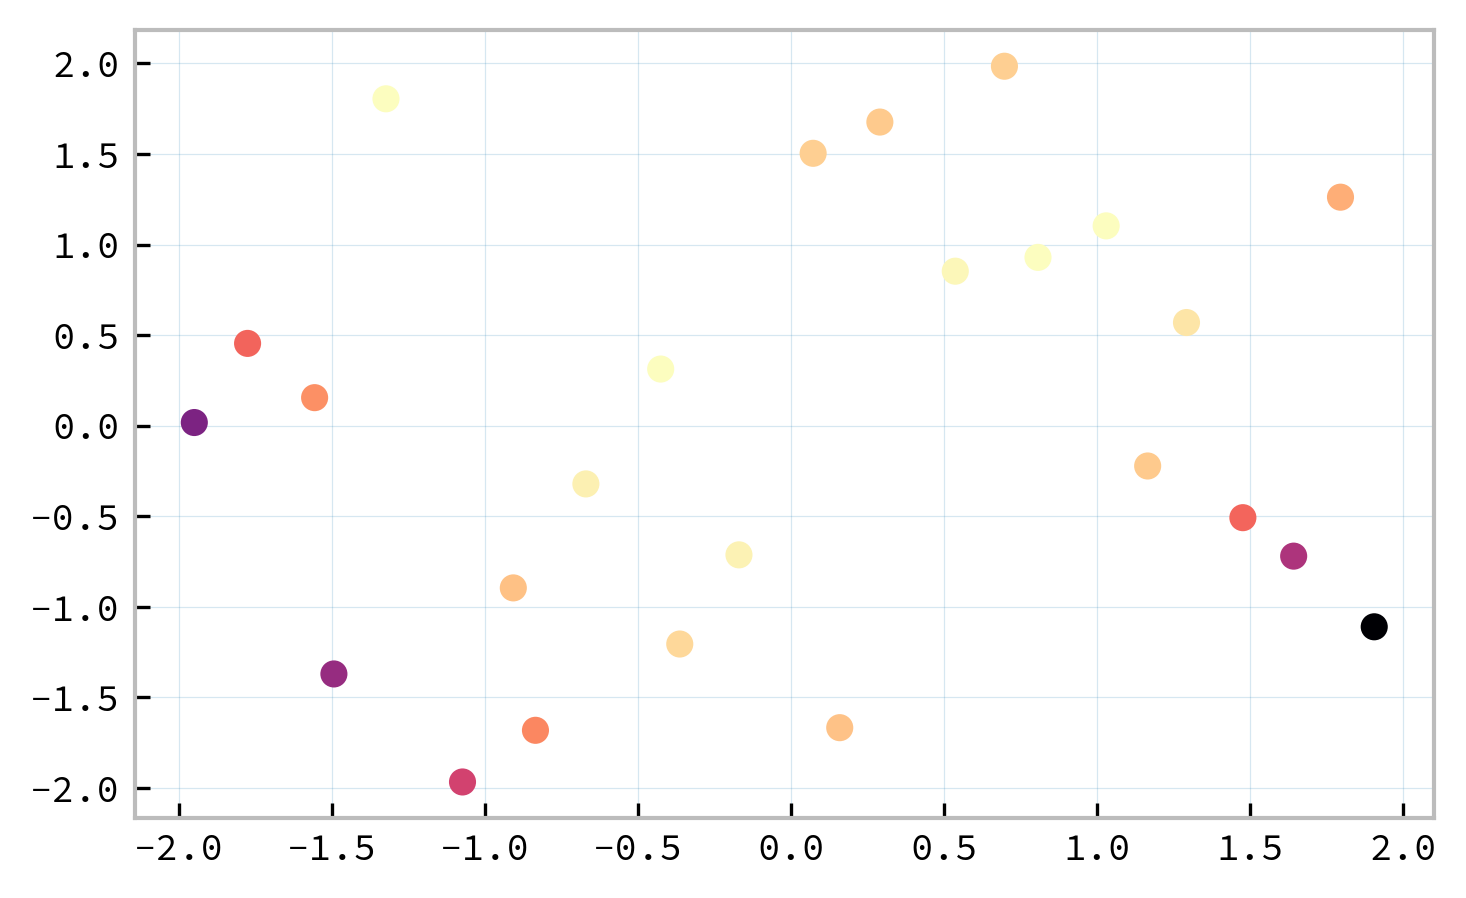

In [34]:
x = np.linspace(-2,2, 5)
y = np.linspace(-2,2, 5)
xy = lhs(2, samples=25) * 4 - 2
rosen_latin = np.array([rosen_function(xx) for xx in xy])

f, ax = plt.subplots(1,1, dpi=300)
ax.scatter(xy[:,0], xy[:, 1], c=rosen_latin)
ax.grid(which="both", zorder=99)
f = thesis.thesisify(f);

In [35]:
with pm.Model() as model:

    amp = pm.Normal("amplitude", 1, 1)
    ls = [0.012, 0.012] #
    ls = pm.Normal("metric", mu=[.1, .1], sd=1, shape=2) #pm.Gamma("metric", alpha=3, beta=0.5, shape=2)
    #ls = pm.Gamma("metric", alpha=.03, beta=0.015, shape=2)
    #period = pm.Gamma("period", alpha=1, beta=0.5)
    alpha = pm.Gamma("alpha", alpha=5, beta=.5, shape=1)
    # Specify the covariance function.
    cov_func = amp * pm.gp.cov.ExpQuad(2, ls=[1, 1]) #+ pm.gp.cov.WhiteNoise(1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0.1, 0.001)
    y_ = gp.marginal_likelihood("y", X=xy, y=rosen_latin, noise=sigma)

    mp = pm.find_MAP()

logp = -1.0256e+05, ||grad|| = 44,534: 100%|██████████| 29/29 [00:00<00:00, 460.16it/s]      


In [36]:
def neg_model_variance(p):
    p = np.atleast_2d(p)
    with model:
        mu, var = gp.predict(p, point=mp, diag=True)
        return -var

In [37]:
from scipy.optimize import minimize

In [38]:
x = np.linspace(-2,2, 50)
y = np.linspace(-2,2, 50)
xy_pred = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
with model:
    mu, var = gp.predict(xy_pred, point=mp, diag=True)
    sd = np.sqrt(var)

In [42]:
new = minimize(neg_model_variance, x0=np.array([[0,0]]))

Problem occurred during compilation with the command line below:
/usr/bin/g++ -shared -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -march=haswell -mmmx -mno-3dnow -msse -msse2 -msse3 -mssse3 -mno-sse4a -mcx16 -msahf -mmovbe -maes -mno-sha -mpclmul -mpopcnt -mabm -mno-lwp -mfma -mno-fma4 -mno-xop -mbmi -mbmi2 -mno-tbm -mavx -mavx2 -msse4.2 -msse4.1 -mlzcnt -mrtm -mhle -mrdrnd -mf16c -mfsgsbase -mno-rdseed -mno-prfchw -mno-adx -mfxsr -mxsave -mxsaveopt -mno-avx512f -mno-avx512er -mno-avx512cd -mno-avx512pf -mno-prefetchwt1 -mno-clflushopt -mno-xsavec -mno-xsaves -mno-avx512dq -mno-avx512bw -mno-avx512vl -mno-avx512ifma -mno-avx512vbmi -mno-clwb -mno-mwaitx --param l1-cache-size=32 --param l1-cache-line-size=64 --param l2-cache-size=6144 -mtune=haswell -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -m64 -fPIC -I/home/daniel/.virtualenvs/aries/thesis2/local/lib/python2.7/site-packages/numpy/core/include -I/usr/include/python2.7 -I/home/daniel/.virtualenvs/a

OSError: [Errno 12] Cannot allocate memory

NameError: name 'new' is not defined

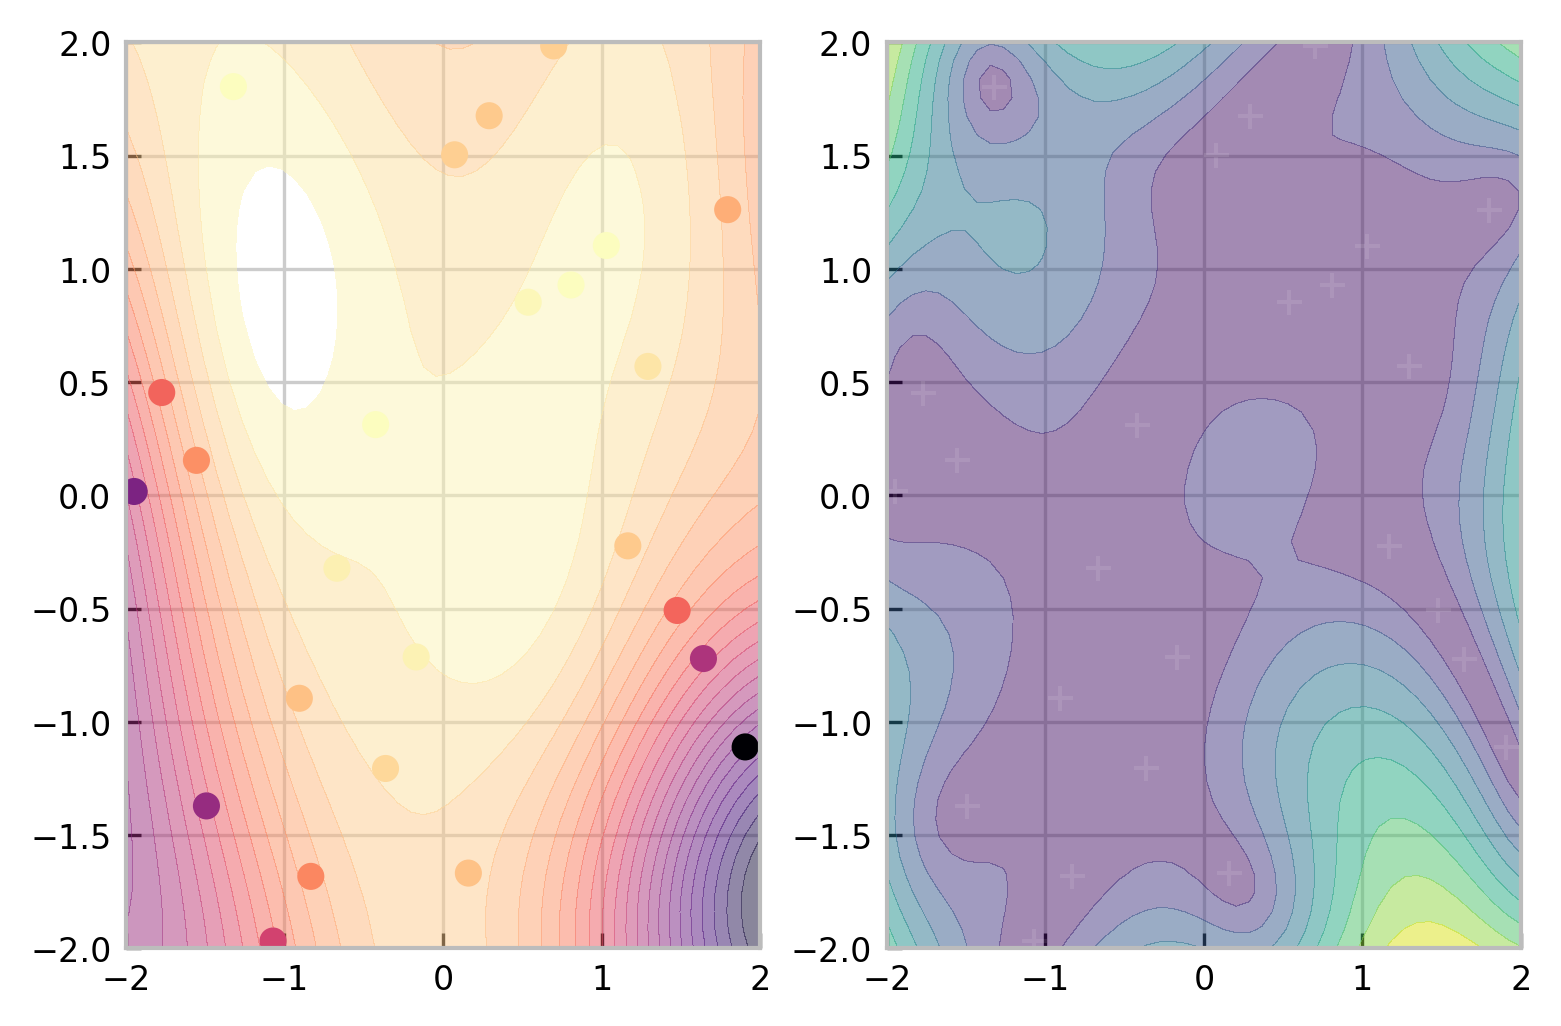

In [41]:
f, ax = plt.subplots(1,2, dpi=300)
ax[0].contourf(x, y, mu.reshape(50,50), levels=np.arange(-100, 3610, 150), zorder=1, alpha=0.5)
ax[0].grid(which="both", zorder=99)

ax[0].scatter(xy[:, 0], xy[:, 1], c=rosen_latin)

ax[1].contourf(x, y, sd.reshape(50,50), levels=np.arange(0, 10, 1), zorder=1, alpha=0.5, cmap='viridis')
ax[1].grid(which="both", zorder=99)

ax[1].plot(xy[:, 0], xy[:, 1], '+', alpha=0.1, color='white')

ax[0].set_xlim([-2,2])
ax[0].set_ylim([-2,2])

ax[0].plot(new.x[0], new.x[1], 'ob')
ax[1].plot(new.x[0], new.x[1], 'ob')

f = thesis.thesisify(f);

f.tight_layout()

f.savefig("../../figures/gp/infill-max-uncertainty.pdf")

# Voronoi tiling

In [40]:
choice = np.random.choice(len(xy), 25)

In [ ]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
vor = Voronoi(xy[choice],)

In [ ]:
f,ax = plt.subplots(1,1, dpi=300)
f = voronoi_plot_2d(vor, ax)
f = thesis.thesisify(f);

In [ ]:
thesis.thesisify(f)
f.axes[0].plot(vor.vertices[3][0], vor.vertices[3][1], 'o')

In [ ]:
import scipy

In [ ]:
distances = scipy.spatial.distance.cdist(vor.vertices, xy[choice])
np.unravel_index(distances.argmax(), distances.shape)

In [ ]:
vor.vertices[3]